# Code for Assignment 3
by Simon Majgaard and Felipe Riccó Blanco 

## Problem 3.1: Sparse Signal Representation

In [20]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fftpack import idct, dct
from sklearn.linear_model import LassoLarsCV

### 3.1.2: Signal Reconstructing through LassoLars

Found sparcity coefficient: 0.025957948299978346
Number of non-zero weights (K): 4
Non-zero DCT coefficients (mj): (array([ 4,  9, 24, 49]),)
Model coefficients (alpha): [0.18855789 0.38581917 0.43470523 0.23773391]


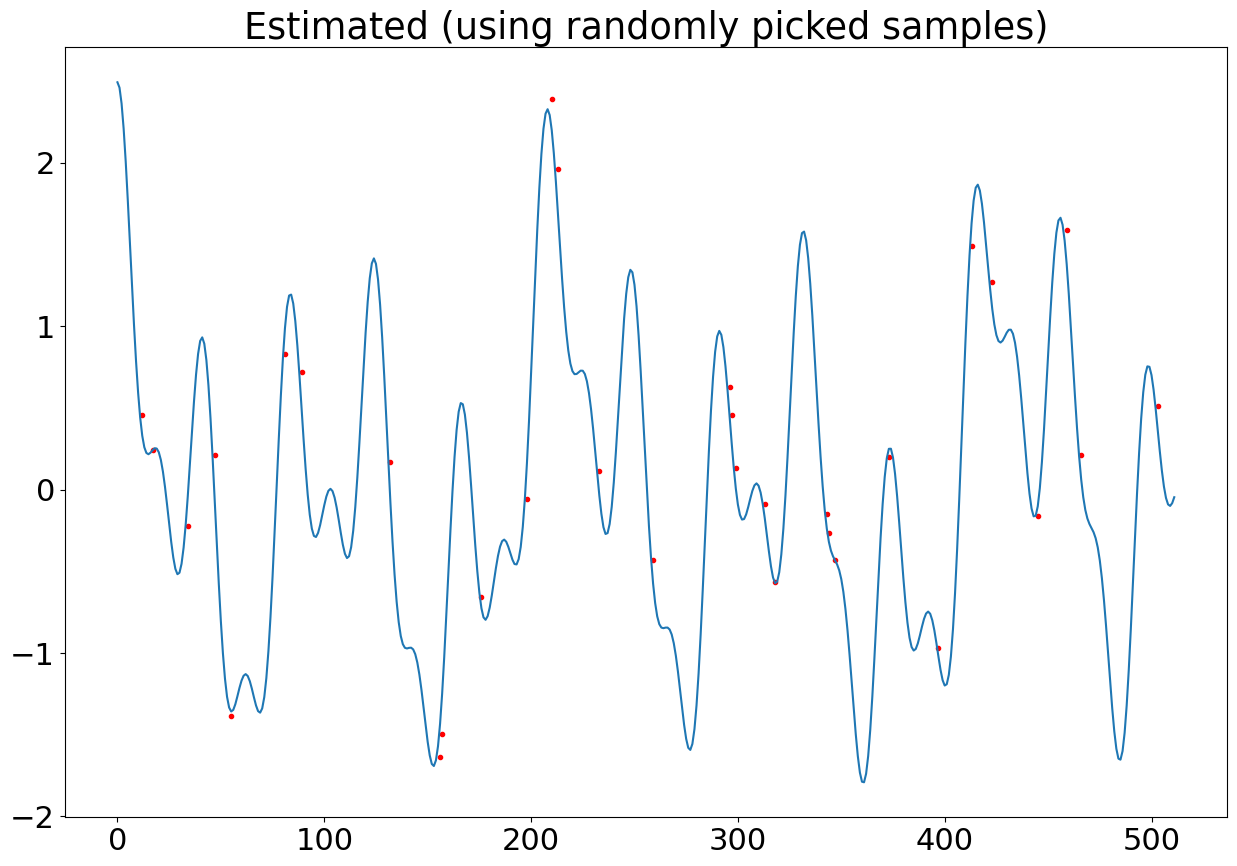

In [28]:
# Load Data
problem = 'problem3_1'
matdata = loadmat(f'{problem}.mat')
n = matdata['n']
y = matdata['x'].squeeze()
l = 2**9;
N =len(y); 

# Construct the sensing matrix
B = np.zeros(shape=(N, l))
for i in range(0, N-1):
    B[i, n[i,:]-1] = 1

# Use idct to compute dct type 3,  representation of the sensing matrix (i.e. X*Phi)
BF = idct(B, axis=1)

# Use LassoLarsCV to perform Lasso regression and cross validate for alpha
model = LassoLarsCV(fit_intercept=False,  max_iter=int(1e6))
model.fit(BF, y)

# Print the results
print(f'Found sparcity coefficient: {model.alpha_}')
solsB = model.coef_
print(f'Number of non-zero weights (K): {np.count_nonzero(solsB)}')
print(f'Non-zero DCT coefficients (mj): {np.nonzero(solsB)}')
print(f'Model coefficients (alpha): {solsB[np.nonzero(solsB)]}')

# Take the inverse IDCT (i.e. the DCT) in order to compute the estimated signal.
x_hat = dct(solsB, axis=0)  

# Plot the results
plt.figure(4, figsize=(15,10))
plt.plot(n, y, 'r.', label='Original signal')
plt.title('Original + Samples taken')
plt.plot(x_hat)
plt.title('Estimated (using randomly picked samples)')
plt.show()


## 3.3: ICA 

In [32]:
# Independent Component Analysis function
def ICA(x, mu, num_components, iters, mode):
    # Random initialization
    W = np.random.rand(num_components, num_components)
    N = np.size(x, 0)

    if mode=='superGauss':
        phi = lambda u : 2*np.tanh(u)
    elif mode=='subGauss':
        phi = lambda u : u-np.tanh(u)
    else:
        print("Unknown mode")
        return W

    for i in range(iters):
        u = W @ x.T # solution  
        dW = (np.eye(num_components) - phi(u) @ u.T/N) @ W  # solution  
        # Update
        W = W + mu*dW   
    return(W)

[[-0.02287393  0.55950339]
 [ 0.62410178  0.0403804 ]]


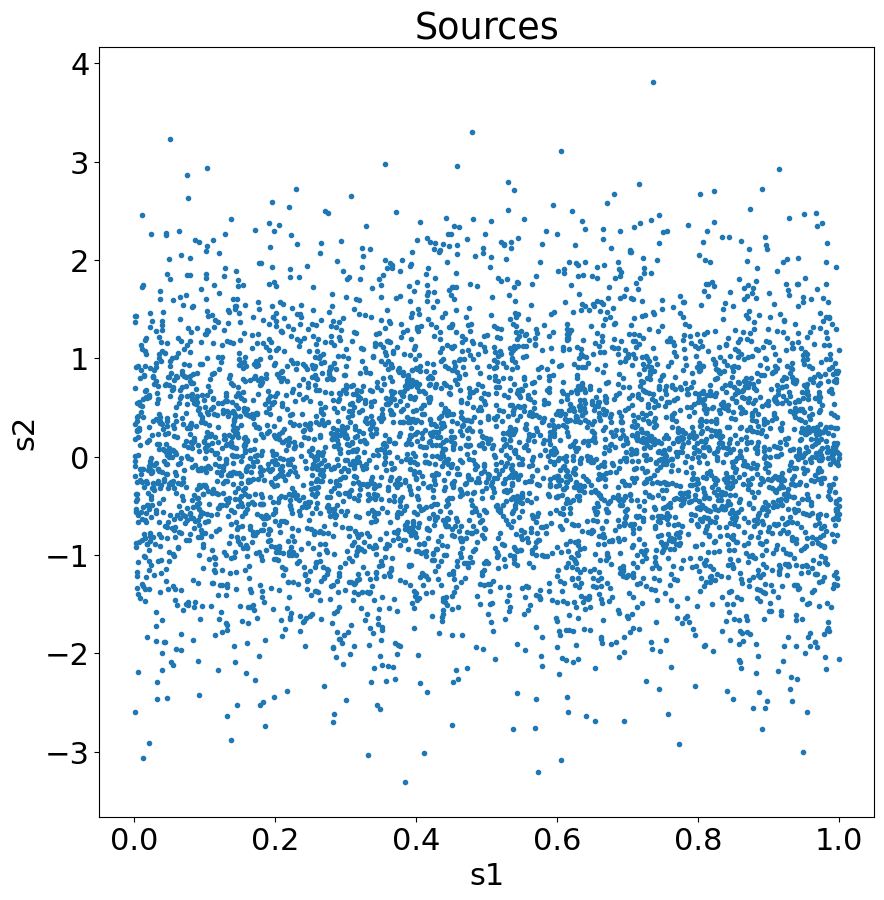

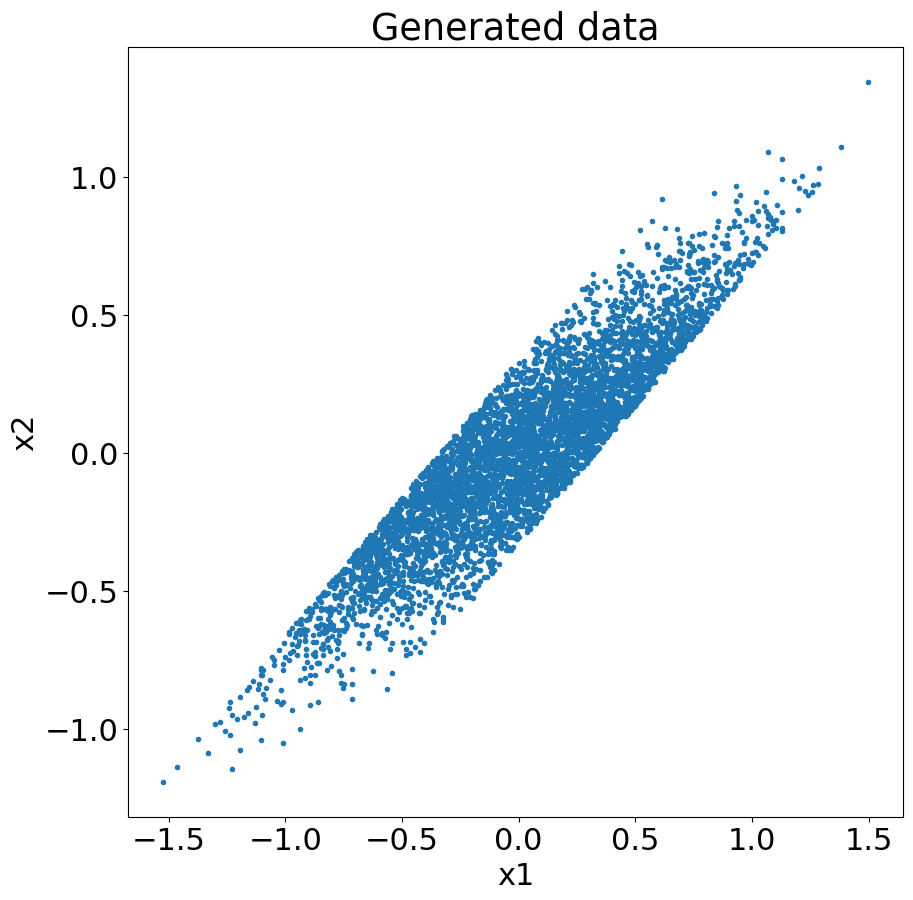

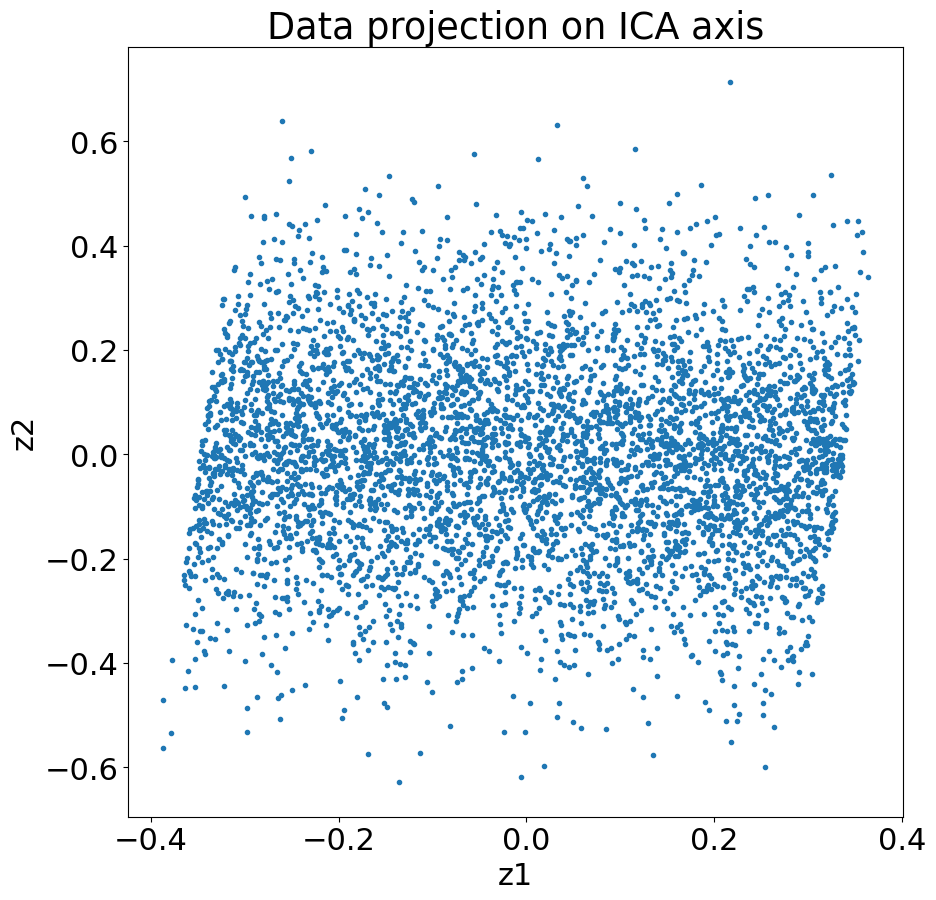

In [33]:
#plotting
plt.rcParams.update({'font.size': 22})
# generate data
N = 5000
A = [[3, 1], [1, 1]];
repetitions=100;
Amean = np.zeros(shape=(2,2))
case = 2;

for i in range(0,repetitions):
    if  case==0:
        # generate data with uniform distribution
        r = np.random.rand(N,2); 
    elif case==1:
        # generate data with uniform distribution and beta distribution
        r1 = np.random.rand(N,1); 
        r2 = np.random.beta(0.1,0.1,(N,1));   
        r = np.concatenate((r1,r2), axis=1); 
    elif case == 2:
         # generate data with uniform distribution and normal distribution
        r1 = np.random.rand(N,1); 
        r2 = np.random.normal(0,1,(N,1));
        r = np.concatenate((r1,r2), axis=1);
    elif case == 3:
        cov = [[2, 0.25], [0.25, 1]];
        mean= [0, 1];
        # generate data with uniform distribution
        r =np.random.multivariate_normal(mean, cov, size=N, check_valid='warn')
    
    else:
        # generate data with uniform distribution
        r = np.random.rand(N,2);


    
    x = (A@r.T).T;

    # ica parameters
    mu = 0.1;
    components = 2;
    iterations = 200;

    # Mean across the first (column) axis
    col_means = np.mean(x, axis=0)
    x = x - col_means

    # run ICA
    W = ICA(x, mu, components, iterations, 'subGauss')

    # Normalize unmixing matrix
    A= np.divide(A,np.max(A));
    W = np.divide(W, np.max(W))
    Ahat=np.linalg.inv(W);
    Ahat = np.divide(Ahat, np.max(Ahat));

    # Compute unmixed signals
    y = (W@x.T).T


    # Compute error in unmixing matrix
    def ICAerror(Ahat,A):
        unmixinerror1=Ahat-A;
        unmixingerror2=np.fliplr(Ahat)-A;
        u=np.linalg.norm(unmixinerror1,'fro'); #Frobenius norm of the error matrix 
        k=np.linalg.norm(unmixingerror2,'fro'); #Frobenius norm of the error matrix
        if u<k:
            return unmixinerror1;   
        else:   
            return unmixingerror2;
     
    norm=ICAerror(Ahat,A)
    Amean=Amean+norm;   

Amean=Amean/repetitions;
print(Amean)

# plot sources
plt.figure(figsize=(10,10))
plt.plot(r[:,0],r[:,1],'.')
plt.title('Sources')
plt.ylabel('s2')
plt.xlabel('s1')
plt.show()

# plot generated data
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'.')
plt.title('Generated data')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

# plot data projection on ica axis
plt.figure(figsize=(10,10))
plt.title('Data projection on ICA axis')
plt.plot(y[:,0],y[:,1],'.')
plt.ylabel('z2')
plt.xlabel('z1')
plt.show()



## 3.5 Kalman Filter

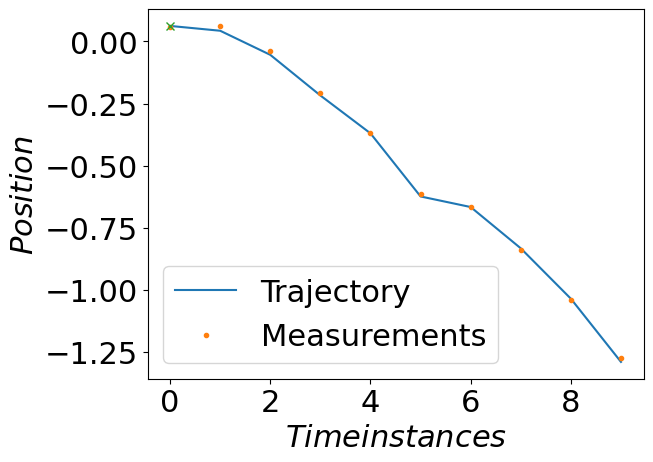

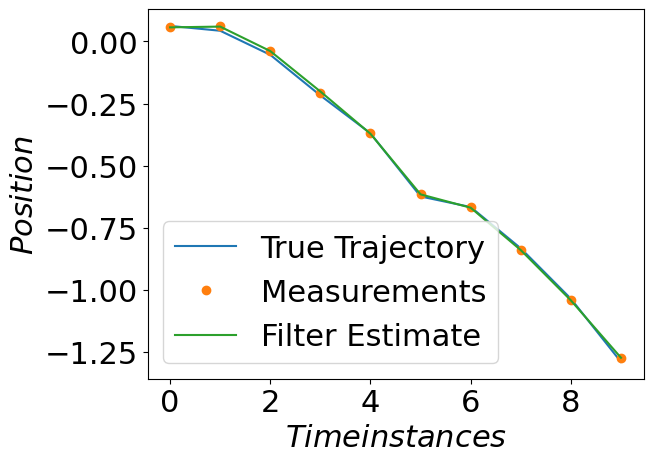

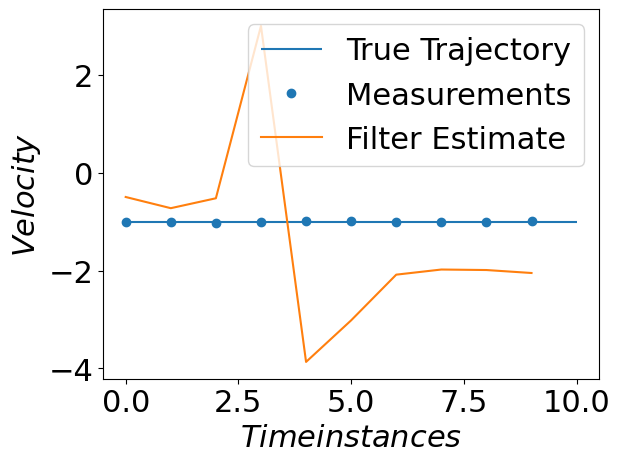

array([[9.92050086e-05, 1.88195850e-04],
       [1.88195850e-04, 1.98951427e-01]])

In [35]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


# Set the parameters
dt = 0.1 # Time step
s = 0.01 # Standard deviation of the measurements
k=0.01 # Process variance of position and velocity
alpha = 0.0001 # Process covariance between position and velocity

# Define the model
A = np.array([
    [1, dt,],
    [0, 1,]
])
Q = np.array([
    [k, alpha],
    [alpha,  k]
])

H = np.array([
    [1, 0],
    [0, 0]])
R = s**2*np.identity(2)
m0 = np.array([[0], [-1]])
P0 = np.array([[.001, .1], [.1, .001]])
steps = 10

# Simulate data
np.random.seed(1)

X = np.zeros((len(A), steps))
Y = np.zeros((len(H), steps))
t = m0
for k in range(steps):
    q = np.linalg.cholesky(Q)@np.random.randn(len(A), 1)
    t = A@t + q
    y = H@t + s*np.random.randn(2, 1)
    X[:, k] = t[:, 0]
    Y[:, k] = y[:, 0]

plt.figure()
plt.plot(X[0, :], '-')
plt.plot(Y[0, :], '.')
plt.plot(X[0, 0], 'x')
plt.legend(['Trajectory', 'Measurements'])
plt.xlabel('$Time instances$')
plt.ylabel('$Position$')


# Kalman filter
m = m0
P = P0
kf_m = np.zeros((len(m), Y.shape[1]))
kf_P = np.zeros((len(P), P.shape[1], Y.shape[1]))
for k in range(Y.shape[1]):
    m = A@m
    P = A@P@A.T + Q

    v = Y[:, k].reshape(-1, 1) - H@m
    S = H@P@H.T + R
    K = P@H.T@np.linalg.inv(S)
    m = m + K@v
    P = P - K@S@K.T

    kf_m[:, k] = m[:, 0]
    kf_P[:, :, k] = P

rmse_raw = np.sqrt(np.mean(np.sum((Y - X[:2, :])**2, 1)))
rmse_kf = np.sqrt(np.mean(np.sum((kf_m[:2, :] - X[:2, :])**2, 1)))


# Plot of Position
plt.figure()
plt.plot(X[0, :], '-')
plt.plot(Y[0, :], 'o')
plt.plot(kf_m[0, :], '-')
plt.legend(['True Trajectory', 'Measurements', 'Filter Estimate'])
plt.xlabel('$Time instances$')
plt.ylabel('$Position$')

plt.show()

# Plot of Velocity
plt.figure()
#plt.plot(X[1, :], '-')
plt.hlines(m0[1],0,steps,label='True velocity')
plt.plot(m0[1] + Y[1, :], 'o')
plt.plot(kf_m[1, :], '-')

plt.legend(['True Trajectory', 'Measurements', 'Filter Estimate'])
plt.xlabel('$Time instances$')
plt.ylabel('$Velocity$')

plt.show()

## 3.6 Kernel methods

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

### 3.6.1 Data loading

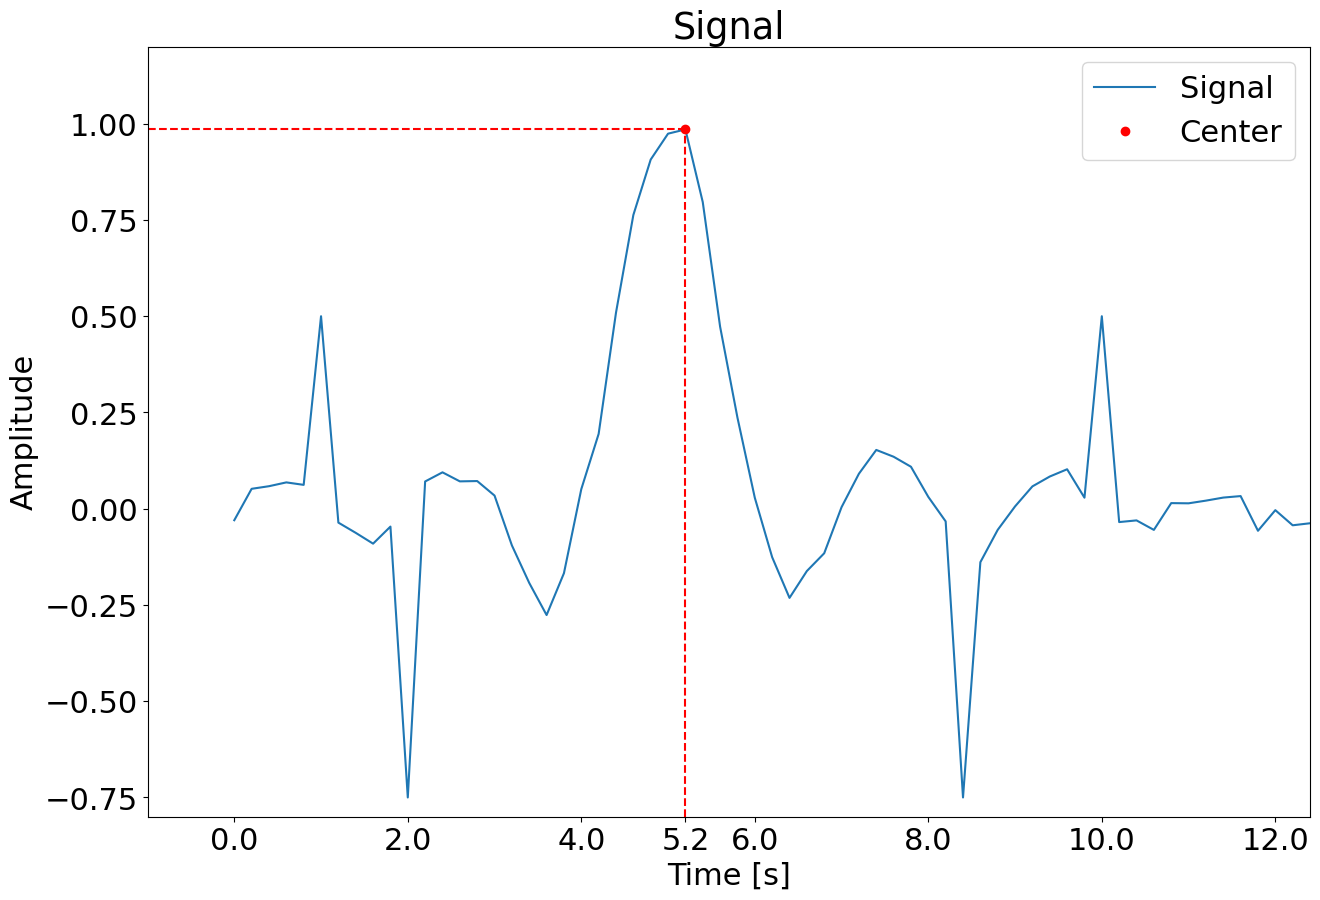

In [39]:
problem= 'problem3_6'
matdata = loadmat(f'{problem}.mat')
y = matdata['y'].squeeze()
t = matdata['t'].squeeze()
N = len(y)

# center of signal
max_idx = np.argmax(y)
ymax, center = y[max_idx], t[max_idx]

# Plot the signal
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
plt.plot(t, y)
plt.plot(center, ymax, 'ro')
plt.legend(['Signal', 'Center'], )
plt.xticks(list(plt.xticks()[0]) + [round(center,2)])
plt.xlim(-1, max(t))
plt.ylim(-.8, 1.2)
plt.hlines(ymax, -1, center, linestyles='dashed', colors='r')
plt.vlines(center, -.8, ymax, linestyles='dashed', colors='r')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Signal')
plt.show()


### 3.6.2: Kernel Ridge Regression

'snr=6.92'

'center=5.00'

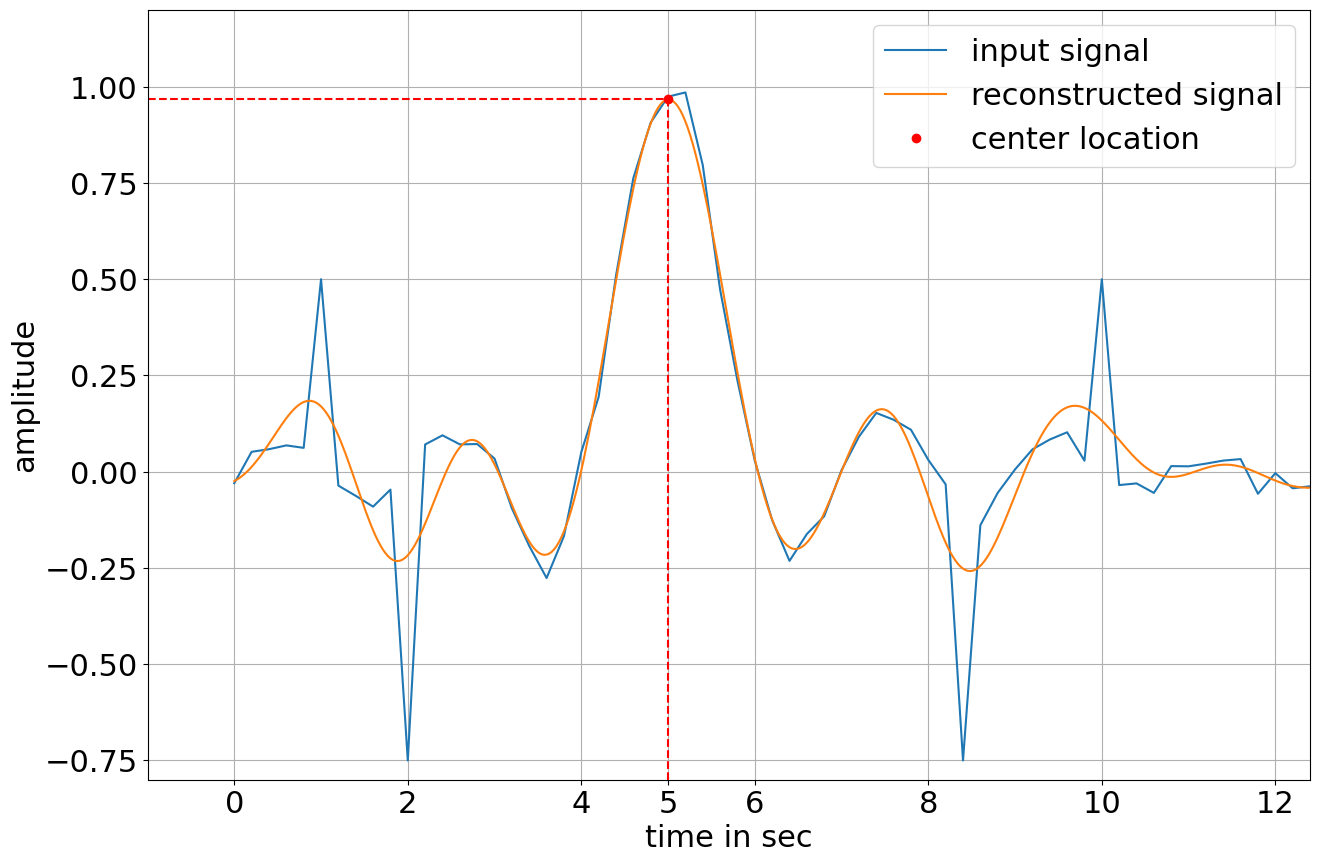

In [44]:
# learning parameters
sigma = 1 # kernel width
C = .1 # regularization parameter
samples_multiplier = 7 # number of samples to take per period

# Upsample the signal
samples = samples_multiplier*N - (samples_multiplier-1)
t_sample = np.linspace(t[0], t[-1], samples) 
indices = np.arange(0, samples, samples_multiplier) 

# unbiased L2 Kernel Ridge Regression (KRR-L2)

# build kernel matrix
pair_dist = np.abs(t.reshape(-1, 1) - t.reshape(1, -1)) # solution  
K = np.exp(-1/(sigma**2)*pair_dist**2) # solution  
A = C*np.identity(N) + K # solution  
sol = np.linalg.solve(A, y)

# Generate regressor
z0 = np.zeros(samples)
for k in range(samples):
    z0[k] = 0
    for j in range(N):
        value = np.exp(-1/(sigma**2)*(t[j] - t_sample[k])**2)
        z0[k] += sol[j]*value


# Compute error
error = y - z0[indices]

# SNR in dB
snr = 10*np.log10(np.sum(z0[indices]**2)/np.sum(error**2))
display(f'{snr=:.2f}')

# Center loaction
max_idx = np.argmax(z0)
ymax, center = z0[max_idx], t_sample[max_idx]
display(f'{center=:.2f}')

# plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.set_xlabel('time in sec')
ax.set_ylabel('amplitude')
ax.plot(t, y, label='input signal')
ax.plot(t_sample, z0, label='reconstructed signal')
ax.plot(center, ymax, 'ro', label='center location')
ax.set_xticks(list(ax.get_xticks()) + [round(center,3)])
ax.set_xlim(-1, max(t))
ax.set_ylim(-.8, 1.2)
ax.vlines(center, -.8, ymax, linestyles='dashed', colors='r')
ax.hlines(ymax, -1, center, linestyles='dashed', colors='r')
ax.legend()
ax.grid()
plt.show()



### 3.6.3: SVR smoothing

'snr=18.48'

'center=5.04'

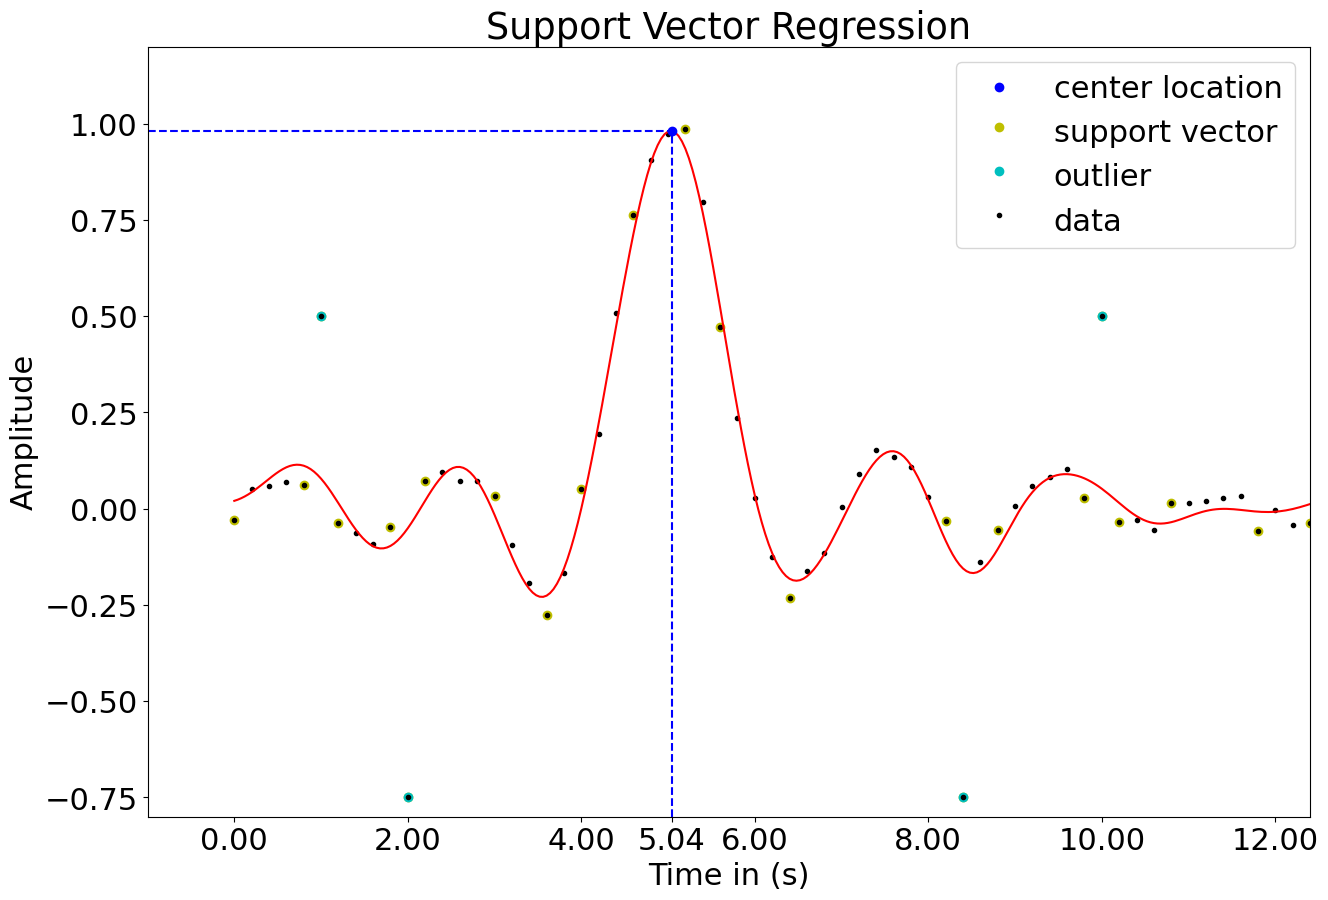

In [46]:
from sklearn.svm import SVR

## Upsampling the signal
samples_multiplier = 5
samples = samples_multiplier*N - (samples_multiplier-1)
t_sample = np.linspace(t[0], t[-1], samples) 
indices = np.arange(0, samples, samples_multiplier)

# model parameters
epsilon=.05
kernel_type='Gaussian'
kernel_params=0.8
C=2

gamma = 1/(np.square(kernel_params)) # gamma needs to be calculated in order to use 'Gaussian' kernel, which is not available in the library
regressor = SVR(kernel='rbf', gamma=gamma, C=C, epsilon=epsilon)

# convert data to proper dimensions in order to fit requirements of the library
x_col = t.reshape(( np.size(t), 1))
y_row = np.copy(y)
t_col = t_sample.reshape(( np.size(t_sample), 1))

t_col = np.around(t_col, decimals=4)
x_col = np.around(x_col, decimals=4)
y_row = np.around(y_row, decimals=4)

regressor.fit(x_col,y_row)
y_pred = regressor.predict(t_col)

# Outlier detection
outliers = regressor.support_[(np.abs(regressor.dual_coef_) >= C).squeeze()]

# SNR in dB without outliers
mask = np.ones(len(t), dtype=bool)
mask[outliers] = False
error = y[mask] - y_pred[indices][mask]
snr = 10*np.log10(np.sum(y_pred[indices][mask]**2)/np.sum(error**2))
display(f'{snr=:.2f}')

# Center loaction
max_idx = np.argmax(y_pred.squeeze())
ymax, center = y_pred[max_idx], t_sample[max_idx]
display(f'{center=:.2f}')

# plot
plt.figure(figsize=(15,10))
plt.stem(x_col[regressor.support_], y_row[regressor.support_], linefmt = 'none', markerfmt='yo', label='support vector', basefmt=" ", )
plt.stem(x_col[outliers], y_row[outliers], linefmt = 'none', markerfmt='co', label='outlier', basefmt=" ", )
plt.stem(x_col, y_row,  linefmt = 'none', markerfmt='k.', label='data', basefmt=" ", )
plt.plot(t_col, y_pred, color = 'red') 
plt.plot(center, ymax, 'bo', label='center location')
plt.xticks(list(plt.xticks()[0]) + [round(center,3)])
plt.xlim(-1, max(t))
plt.ylim(-.8, 1.2)
plt.vlines(center, -.8, ymax, linestyles='dashed', colors='b')
plt.hlines(ymax, -1, center, linestyles='dashed', colors='b')
plt.title("Support Vector Regression")
plt.xlabel("Time in (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()